# Implementation

## Setting up Tensorflow
Restart runtime, set it to GPU and then run this chunk. The default is tf2.x which has slightly different functions. I prefer working with tf1.x

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


## Loading Dataset
Loading the EEG dataset from physionet databases [1]. Physionet allows us to load dataset directly from cloud. 

In [ ]:
# !wget -r -N -c -np https://physionet.org/files/chbmit/1.0.0/
!gsutil -m cp -r gs://chbmit-1.0.0.physionet.org DESTINATION

Copying gs://chbmit-1.0.0.physionet.org/RECORDS...
Copying gs://chbmit-1.0.0.physionet.org/SHA256SUMS.txt...
Copying gs://chbmit-1.0.0.physionet.org/RECORDS-WITH-SEIZURES...
Copying gs://chbmit-1.0.0.physionet.org/ANNOTATORS...
Copying gs://chbmit-1.0.0.physionet.org/chb-mit-scalp-eeg-database-1.0.0.zip...
Copying gs://chbmit-1.0.0.physionet.org/SUBJECT-INFO...
Copying gs://chbmit-1.0.0.physionet.org/shoeb-icml-2010.pdf...
Copying gs://chbmit-1.0.0.physionet.org/chb01/chb01-summary.txt...
Copying gs://chbmit-1.0.0.physionet.org/chb01/chb01_01.edf...
Copying gs://chbmit-1.0.0.physionet.org/chb01/chb01_02.edf...
Copying gs://chbmit-1.0.0.physionet.org/chb01/chb01_03.edf...
Copying gs://chbmit-1.0.0.physionet.org/chb01/chb01_03.edf.seizures...
Copying gs://chbmit-1.0.0.physionet.org/chb01/chb01_04.edf...
Copying gs://chbmit-1.0.0.physionet.org/chb01/chb01_04.edf.seizures...
Copying gs://chbmit-1.0.0.physionet.org/chb01/chb01_05.edf...
Copying gs://chbmit-1.0.0.physionet.org/chb01/chb01_06

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Checking some files content.

In [2]:
file = '/content/DESTINATION/chbmit-1.0.0.physionet.org/chb01/chb01-summary.txt'
f = open(file, 'r')
file_contents = f.read()
print(file_contents)

Data Sampling Rate: 256 Hz
*************************

Channels in EDF Files:
**********************
Channel 1: FP1-F7
Channel 2: F7-T7
Channel 3: T7-P7
Channel 4: P7-O1
Channel 5: FP1-F3
Channel 6: F3-C3
Channel 7: C3-P3
Channel 8: P3-O1
Channel 9: FP2-F4
Channel 10: F4-C4
Channel 11: C4-P4
Channel 12: P4-O2
Channel 13: FP2-F8
Channel 14: F8-T8
Channel 15: T8-P8
Channel 16: P8-O2
Channel 17: FZ-CZ
Channel 18: CZ-PZ
Channel 19: P7-T7
Channel 20: T7-FT9
Channel 21: FT9-FT10
Channel 22: FT10-T8
Channel 23: T8-P8

File Name: chb01_01.edf
File Start Time: 11:42:54
File End Time: 12:42:54
Number of Seizures in File: 0

File Name: chb01_02.edf
File Start Time: 12:42:57
File End Time: 13:42:57
Number of Seizures in File: 0

File Name: chb01_03.edf
File Start Time: 13:43:04
File End Time: 14:43:04
Number of Seizures in File: 1
Seizure Start Time: 2996 seconds
Seizure End Time: 3036 seconds

File Name: chb01_04.edf
File Start Time: 14:43:12
File End Time: 15:43:12
Number of Seizures in File: 1
S

In [4]:
!pip install pyedflib

Reading Channels: 100%|██████████| 23/23 [00:04<00:00,  4.88it/s]
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


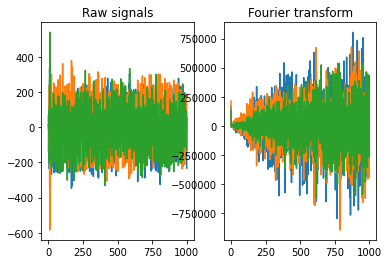

In [3]:
from pyedflib import highlevel
import numpy as np
import matplotlib.pyplot as plt

# read an edf file
file2 = '/content/DESTINATION/chbmit-1.0.0.physionet.org/chb02/chb02_16+.edf'
signals, signal_headers, header = highlevel.read_edf(file2)

dft = np.fft.fft(signals, axis=1)

plt.subplot(1,2,1)
plt.plot(np.transpose(signals[0:3,:1000]))
plt.title('Raw signals')
plt.subplot(1,2,2)
plt.plot(np.transpose(dft[0:3,:1000]))
plt.title('Fourier transform')
plt.show()

## Preproccessing
Some basic data preprocessing includes obtaining signals in frequency domain usinf fft and shaping the data to arrange as labels and training+test data.

### First we will read all the ".edf" and ".txt" files in the directory and stack them.

In [2]:
import os

path = '/content/DESTINATION'

edfFiles = []
txtFiles = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if file[-4:] == '.edf':
            edfFiles.append(os.path.join(r, file))
        elif file[-4:] == '.txt':
            txtFiles.append(os.path.join(r, file))

edfFiles = sorted(edfFiles)
txtFiles = sorted(txtFiles)

for f in edfFiles:
    print(f)

for f in txtFiles:
    print(f)

/content/DESTINATION/chbmit-1.0.0.physionet.org/chb01/chb01_01.edf
/content/DESTINATION/chbmit-1.0.0.physionet.org/chb01/chb01_02.edf
/content/DESTINATION/chbmit-1.0.0.physionet.org/chb01/chb01_03.edf
/content/DESTINATION/chbmit-1.0.0.physionet.org/chb01/chb01_04.edf
/content/DESTINATION/chbmit-1.0.0.physionet.org/chb01/chb01_05.edf
/content/DESTINATION/chbmit-1.0.0.physionet.org/chb01/chb01_06.edf
/content/DESTINATION/chbmit-1.0.0.physionet.org/chb01/chb01_07.edf
/content/DESTINATION/chbmit-1.0.0.physionet.org/chb01/chb01_08.edf
/content/DESTINATION/chbmit-1.0.0.physionet.org/chb01/chb01_09.edf
/content/DESTINATION/chbmit-1.0.0.physionet.org/chb01/chb01_10.edf
/content/DESTINATION/chbmit-1.0.0.physionet.org/chb01/chb01_11.edf
/content/DESTINATION/chbmit-1.0.0.physionet.org/chb01/chb01_12.edf
/content/DESTINATION/chbmit-1.0.0.physionet.org/chb01/chb01_13.edf
/content/DESTINATION/chbmit-1.0.0.physionet.org/chb01/chb01_14.edf
/content/DESTINATION/chbmit-1.0.0.physionet.org/chb01/chb01_15

### Reading EDF files and stacking them in batches. 

In [3]:
from pyedflib import highlevel
import numpy as np
import matplotlib.pyplot as plt


def stacker(nbatch = 15, para):
  count = 0

  if para == 'time':
    stackedEEG = np.zeros((23, 921600))
  elif para == 'freq':
    dft        = np.zeros((23, 921600))
  else:
    labels     = np.zeros((23, 921600))

  rejected   = []

  for f in edfFiles:
    # print(f[54:-4])
    count += 1
    if para == 'time' or para == 'freq':
      signals, signal_headers, header = highlevel.read_edf(f)
    
    if signals.shape == (23, 921600):
      if para == 'time':
        stackedEEG = np.dstack((stackedEEG, signals))
      elif para == 'freq':
        dft        = np.dstack((dft, np.fft.fft(signals, axis=1)))
      else:
        continue
    else:
      rejected.append(f[54:-4])
    
    if count % nbatch == 0:
      if para == 'time':
        yield stackedEEG
        stackedEEG = np.zeros((23, 921600))
      elif para == 'freq':
        yield dft
        dft        = np.zeros((23, 921600)) 
      else:
        yield labels
        labels     = np.zeros((23, 921600))   
      

      # labels     = np.zeros((23, 921600))
      # 

for i in stackTime():
  print(i.shape)

Reading Channels:   0%|          | 0/23 [00:00<?, ?it/s]

(23, 921600, 16)


Reading Channels:   0%|          | 0/23 [00:00<?, ?it/s]

(23, 921600, 13)


Reading Channels:   0%|          | 0/23 [00:00<?, ?it/s]

(23, 921600, 16)


Reading Channels:   0%|          | 0/23 [00:00<?, ?it/s]

(23, 921600, 15)


Reading Channels:   0%|          | 0/23 [00:00<?, ?it/s]

(23, 921600, 16)


Reading Channels:   0%|          | 0/23 [00:00<?, ?it/s]

(23, 921600, 16)


Reading Channels: 100%|██████████| 23/23 [00:04<00:00,  4.74it/s]


In [5]:
# rejected # Those samples which were of different size
i.

(23, 921600, 16)

In [15]:
print(len(stackedEEG))
# for eeg in stackedEEG:
#   print(eeg.shape)
i = 89
print(edfFiles[i])
signals, signal_headers, header = highlevel.read_edf(edfFiles[i])
print(signals.shape)

Reading Channels:   0%|          | 0/23 [00:00<?, ?it/s]

34
/content/DESTINATION/chbmit-1.0.0.physionet.org/chb03/chb03_12.edf


Reading Channels: 100%|██████████| 23/23 [00:04<00:00,  4.94it/s]


(23, 921600)


In [18]:
921600/(1*60*60)

256.0

## Building a CNN


Here we just import some libraries and use them to buid an architecture. 

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import to_categorical

# x_train = trainX.reshape(trainX.shape)
# x_test = testX.reshape(testX.shape)

# x_train = (x_train - 255)/255
# x_test = (x_test - 255)/255

# y_train = to_categorical(trainy)
# y_test = to_categorical(testy)

in1 = Input(shape=x_train[0].shape)
c1 = Conv2D(256, (5,5), activation='relu')(in1)
m1 = MaxPooling2D()(c1)
# c2 = Conv2D(128, (5,5), activation='relu')(m1)
# # m2 = MaxPooling2D()(c2)
# d1 = Dropout(0.7)(c2)
# c3 = Conv2D(256, (5,5), activation='relu')(d1)
# # m3 = MaxPooling2D()(c3)
# d2 = Dropout(0.8)(c3)
# # c4 = Conv2D(64, (3,3), activation='relu')(d2)
# # m4 = MaxPooling2D()(c4)
# fl = Flatten()(d2)
# d1 = Dense(64, activation='relu')(fl)
# d2 = Dense(16, activation='relu')(d1)
o = Dense(len(y_train[0]), activation='softmax')(d2)

model = Model(inputs=in1, outputs=o)
print(model.summary())

Now after we have constructed our model let's train it. 

In [ ]:
model = Model(inputs = in1, outputs = o)
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics=['acc'])
history_cnn = model.fit(x_train, y_train, epochs = 60, batch_size = 32, validation_data = (x_test, y_test))

## Results

In [ ]:
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
epochs = range(1, len(loss) + 1)
pyplot.grid()
pyplot.plot(epochs, loss, 'y', label='Training loss')
pyplot.plot(epochs, val_loss, 'r', label='Validation loss')
pyplot.title('Training and validation loss')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.legend()
pyplot.show()

pyplot.grid()
acc = history_cnn.history['acc']
val_acc = history_cnn.history['val_acc']
epochs = range(1, len(loss) + 1)
pyplot.plot(epochs, acc, 'y', label='Training Accuracy')
pyplot.plot(epochs, val_acc, 'r', label='Validation Accuracy')
pyplot.title('Training and validation Accuracies')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.legend()
pyplot.show()

## Discussion and Conclusion

Yay our implementation is successful...

# Bibliography
[1] CHB-MIT Scalp EEG Database, Retrieved from: https://physionet.org/content/chbmit/1.0.0/
